In [5]:
import snappy
from snappy import HashMap

from pathlib import Path

jpy = snappy.jpy
from snappy import ProductIO, File

import fiona
import os

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cartopy.crs as ccrs
import numpy as np

import rasterio
import rasterio.mask
from rasterio.enums import Resampling

In [4]:
##init variables
File = jpy.get_type('java.io.File') #file type   

pc_base_directory = ('C:/Sentinel 3 Data/') 
laptop_base_directory = ('C:/Users/Massimo/Documents/SchoolFolder/ThirdYear/Thesis/MassThesis/src/TIF/AllBandsTiff')

base_directory = laptop_base_directory
k=0
path = Path(base_directory)
print(path)

C:\Users\Massimo\Documents\SchoolFolder\ThirdYear\Thesis\MassThesis\src\TIF\AllBandsTiff


BoundingBox(left=14.157149834166667, bottom=35.717367270000004, right=14.645328330833333, top=36.11678604)
Rescaled size:  (36, 44)


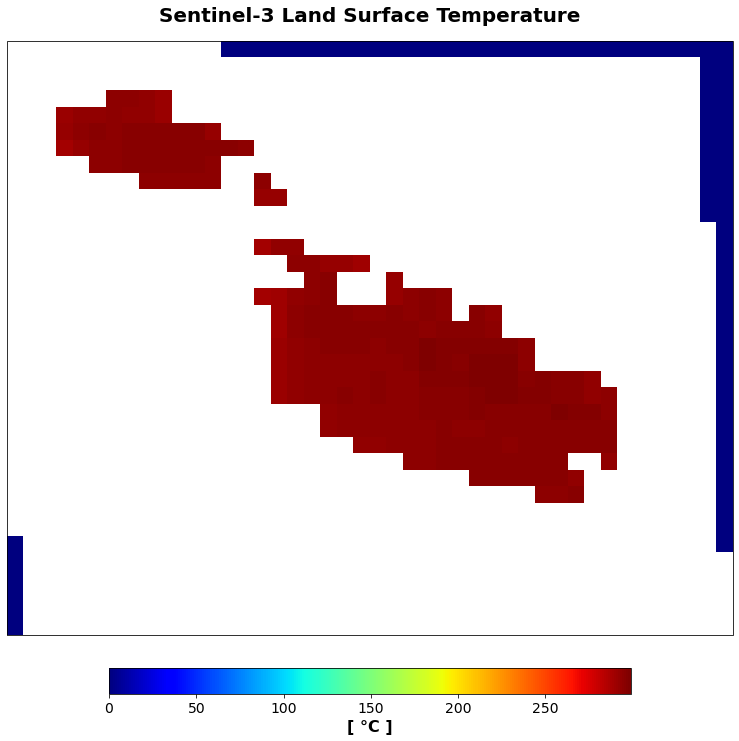

BoundingBox(left=14.152049800000004, bottom=35.70801108666666, right=14.651293150000004, top=36.11850006333333)
Rescaled size:  (37, 45)


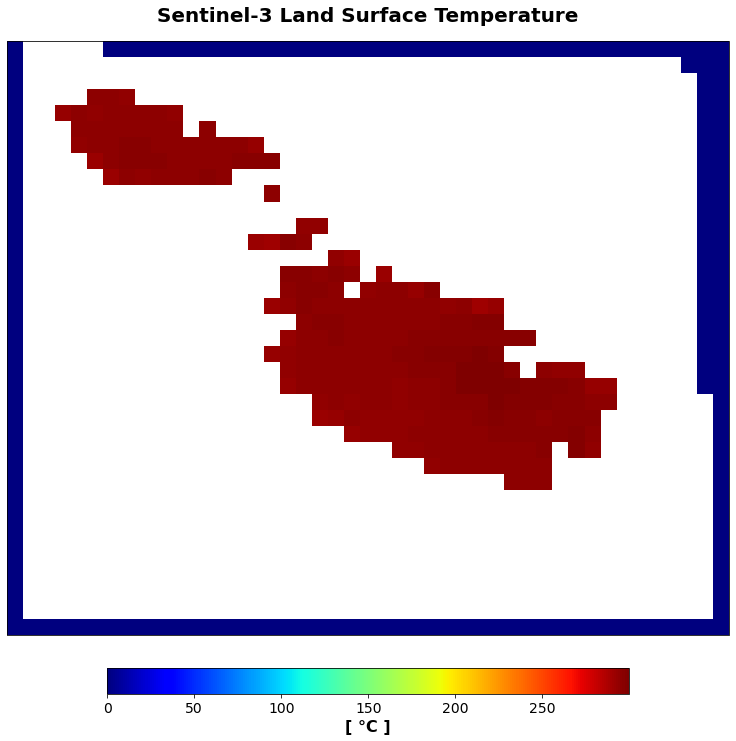

BoundingBox(left=14.153764359999997, bottom=35.70866969666667, right=14.652880134999997, top=36.11905377833333)
Rescaled size:  (37, 45)


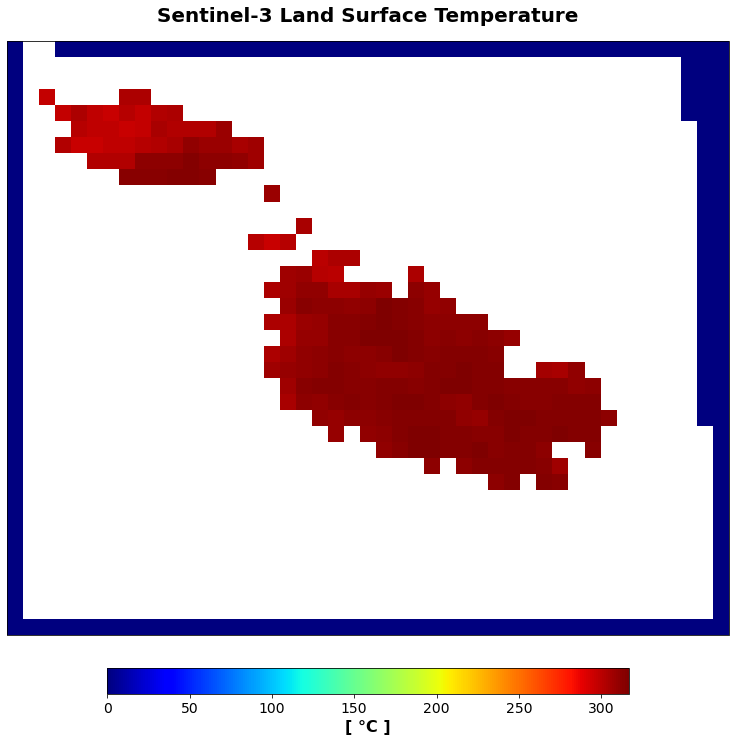

BoundingBox(left=14.155818340000001, bottom=35.71349097499999, right=14.643834880000002, top=36.123868519999995)
Rescaled size:  (37, 44)


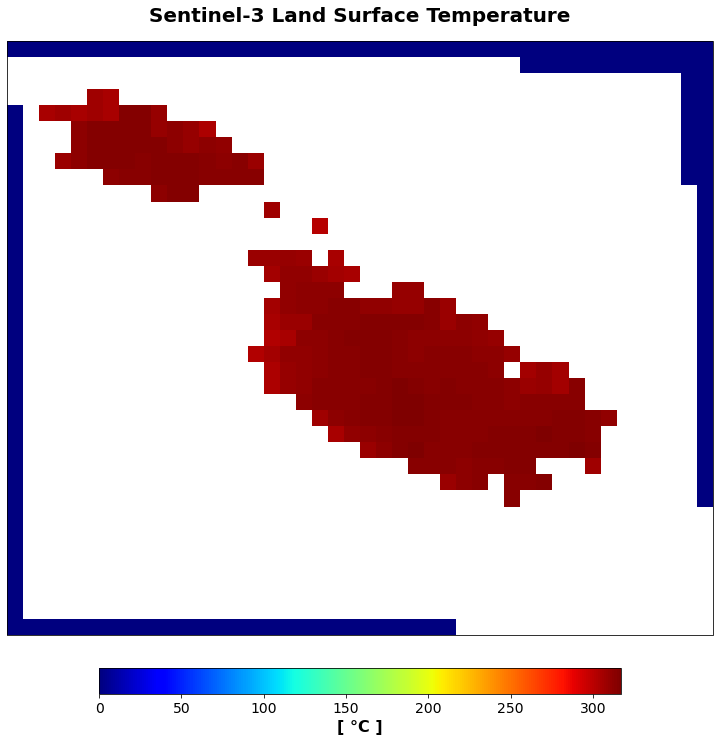

BoundingBox(left=14.157154287468453, bottom=35.7142038849829, right=14.644501348121025, top=36.11452468480466)
Rescaled size:  (92, 112)


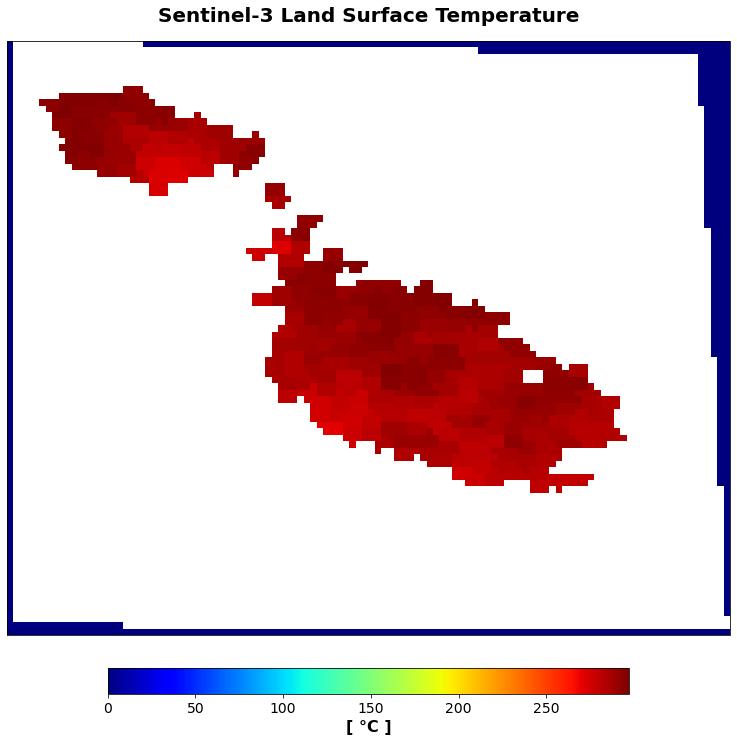

BoundingBox(left=14.158750068769184, bottom=35.716824136795715, right=14.646075268888007, top=36.117126979750466)
Rescaled size:  (92, 112)


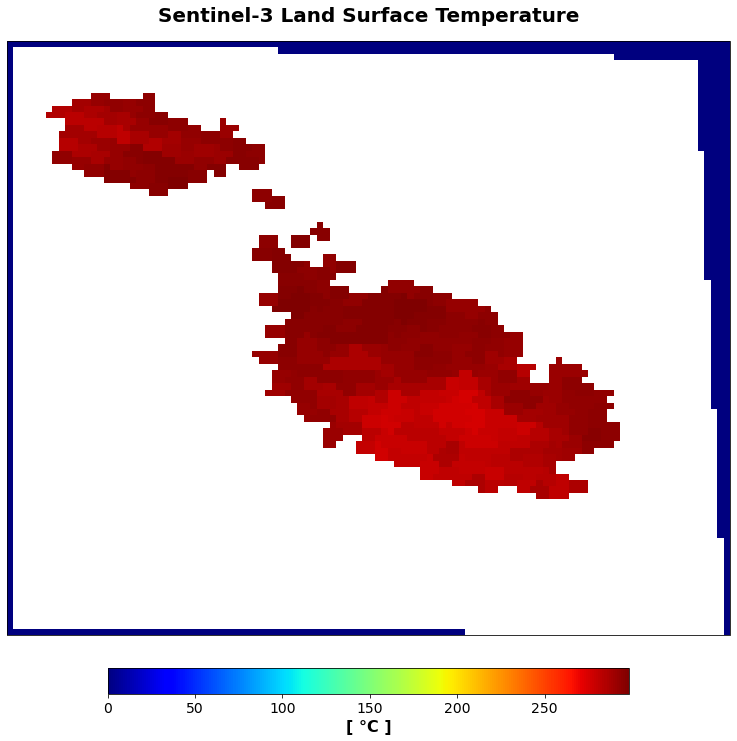

In [16]:
for root, dirs, files in os.walk(base_directory):
    path = root.split(os.sep)
    for name in files:
        product_path = str(os.path.join(root, name))

        with fiona.open("Malta Shape File/MaltaShapeFile.shp", "r") as shapefile:
            shapes = [feature["geometry"] for feature in shapefile]

        with rasterio.open(product_path) as src:
            out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
            out_meta = src.descriptions
            out_meta = src.meta
            out_meta.update({"driver": "GTiff",
                            "height": out_image.shape[1],
                            "width": out_image.shape[2],
                            "transform": out_transform,
                            "dtype": "float32"})
            with rasterio.open('cropped.tif', 'w', **out_meta) as dst:
                # Read the data from the window and write it to the output raster
                dst.meta
                dst.update_tags(**out_meta)
                dst.write(out_image)

            raster = rasterio.open('cropped.tif')
            unit = '[ °C ]'

            long_name = 'Sentinel-3 Land Surface Temperature'

            # We need to know the geographical extent of the data, this is contained in the raster object.

            bbox = raster.bounds
            extent=[bbox[0],bbox[2],bbox[1],bbox[3]]
            #extent=[35.7, 36.1, 14.1, 14.6]
            print (bbox)

            upscale_factor = 1

            # resample data to target shape
            data = raster.read(
            out_shape=(
                raster.count,
                int(raster.height * upscale_factor),
                int(raster.width * upscale_factor)
                    ),
                    resampling=Resampling.bilinear
                )

                # scale image transform
            transform = raster.transform * raster.transform.scale(
            (raster.width / data.shape[-1]),
            (raster.height / data.shape[-2]))

            print('Rescaled size: ',np.shape(data[0,:,:]))

            # Here we set up the parameters needed to display the geographical data correctly.
            fig=plt.figure(figsize=(15, 12))

            # Here we set up a simple Plate Carree geographical projection. This is handled by the Cartopy library.
            #proj = ccrs.epsg(3857)
            #ax = plt.axes(projection=proj)
            ax = plt.axes(projection=ccrs.PlateCarree())

            # The coastline data get downloaded here, there may be a delay the first time you run this notebook.
            #ax.coastlines(resolution='10m')
            #ax.gridlines()
            ax.set_title(long_name, fontsize=20, pad=20.0, fontweight = 'bold')

            # Here we set the colour map for matplotlib. e.g. 'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern', 'jet', also
            # selecting which colour to associate with the NODATA value in the map

            color = cm.jet

            color.set_bad('white')

            #The pixel associated to the NODATA values are masked out.

            data = data.astype(np.float32)
            data[data == -32768.0] = np.nan

            # As the product contains the data in Digital Numbers (DN), it is necessary to calibrate them with the SCALE FACTOR and OFFSET values.
            # These can be retrieved from the extended metadata of the file. 

            scale_factor = 0.0020000001

            offset = 290

            #cal_data = scale_factor * data - 273 + offset
            cal_data = data - 273 + offset

            img = plt.imshow(data[4,:,:], cmap = color,extent = extent,transform=ccrs.PlateCarree())

            cbar = fig.colorbar(img, ax=ax, orientation='horizontal', fraction=0.04, pad=0.05)
            cbar.set_label(unit, fontsize=16, fontweight = 'bold')
            cbar.ax.tick_params(labelsize=14)
            plt.show()